In [35]:
# I have a tendency to import everthing on the planet so I hope u have ram

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import keras_tuner as kt
import keras_cv as kcv

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2L
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.mixed_precision import set_global_policy
from tensorflow.keras.regularizers import l1, l2, L1L2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tifffile as tiff
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import imagecodecs
import cv2
import os
import PIL

from sklearn.utils.class_weight import compute_class_weight

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

import seaborn as sns


/Users/wyatt/Documents/usdabeef/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
df = pd.read_excel('Path1/Path1-Model Training/Path1 Challenge Training Data.xlsx')
directory = 'Path1/Path1-Model Training/Path1 Challenge Training Images/'

In [12]:
def load_images_from_folder(folder, target_size=(224, 224)):
    images = []
    files = sorted(os.listdir(folder))  # Sort the list of files
    for filename in files:
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            resized_img = cv2.resize(img, target_size)  # Resize the image
            images.append(resized_img)
    return np.array(images)

In [13]:
directory = 'Path1/Path1-Model Training/Path1 Challenge Training Images/'

df = pd.read_excel('Path1/Path1-Model Training/Path1 Challenge Training Data.xlsx')
df = df[df['Grade Category'] != 'Standard']

grade_mapping = {'Select': 0, 'Low Choice': 1, 'Upper 2/3 Choice': 2, 'Prime': 3}
class_names = "Select", "Low Choice", "Upper 2/3 Choice", "Prime"

df['Label'] = df['Grade Category'].map(grade_mapping)

In [14]:
file_list = sorted(os.listdir(directory))
df_filtered = df[df['Filename'].isin(file_list)]

In [15]:
df_filtered.shape

(1401, 5)

In [16]:
all_images = load_images_from_folder(directory, target_size=(224, 224))

all_labels = []
filtered_images = []

# extract label from each filename
for filename in file_list:
    if filename in df_filtered['Filename'].values:
        label = df_filtered[df_filtered['Filename'] == filename]['Label'].values[0]
        all_labels.append(label)

        #filter images because the first one file is not in the filtered df
        filtered_images.append(all_images[file_list.index(filename)])

# make them arrays
all_labels = np.array(all_labels)
filtered_images = np.array(filtered_images)

In [17]:
train_data, validation_data = train_test_split(df_filtered, test_size=0.2, random_state=42)

# split the images themselves in case we do some visualizations
train_images, validation_images, train_labels, validation_labels = train_test_split(
    filtered_images,
    all_labels,
    test_size=0.2,
    random_state=42
)

datagen = ImageDataGenerator(rescale=1./255)

In [18]:
print(df_filtered.tail())
print(train_data['Label'].unique())
print(validation_data['Label'].unique())

            Filename  Carcass_ID  Score Grade Category  Label
1397  00008196-1.tif        8196  440.0          Prime      3
1398  00008197-1.tif        8197  476.7          Prime      3
1399  00008198-1.tif        8198  533.3          Prime      3
1400  00008199-1.tif        8199  586.7          Prime      3
1401  00008200-1.tif        8200  676.7          Prime      3
[1 0 2 3]
[2 0 1 3]


In [19]:
# one hot encoding allows for ml to digest categorical data as binary
train_labels_one_hot = to_categorical(train_data['Label'], num_classes=4)
validation_labels_one_hot = to_categorical(validation_data['Label'], num_classes=4)

In [20]:
#oversampling... not the greatest

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(filtered_images.reshape(-1, 224*224*3), all_labels)

X_resampled = X_resampled.reshape(-1, 224, 224, 3)
y_resampled_one_hot = to_categorical(y_resampled, num_classes=4)


In [21]:
# under sampling
sampling_strategy = {
    1: 200,
    2: 200,
    0: 175,
    3: 79
}

rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
X_resampled, y_resampled = rus.fit_resample(filtered_images.reshape(-1, 224*224*3), all_labels)

X_resampled = X_resampled.reshape(-1, 224, 224, 3)
y_resampled_one_hot = to_categorical(y_resampled, num_classes=4)


In [22]:


#augmentation
datagen = ImageDataGenerator(
    rescale=1./255, #normalize!
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest' #brendan said he likes this one
)

# inputs our images into the augment and preps into tensors for model
train_generator = datagen.flow(
    # X_resampled,
    # y_resampled_one_hot,
    all_images[train_data.index],
    train_labels_one_hot,
    batch_size=32,
    shuffle=True
)

# preps images for model
validation_generator = datagen.flow(
    all_images[validation_data.index],
    validation_labels_one_hot,
    batch_size=32,
    shuffle=False
)

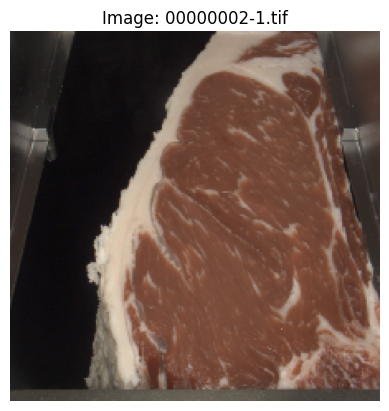

In [23]:
image_filename = df['Filename'].iloc[0]  # first image

image_path = os.path.join(directory, image_filename)

# plot
img = image.load_img(image_path, target_size=(224, 224))
plt.imshow(img)
plt.axis('off')
plt.title(f"Image: {image_filename}")
plt.show()

In [38]:
# check  original balance
class_counts = df_filtered['Grade Category'].value_counts()
print(class_counts)


Grade Category
Low Choice          608
Upper 2/3 Choice    539
Select              175
Prime                79
Name: count, dtype: int64


In [39]:
#post under/oversampling

unique_classes, counts = np.unique(y_resampled, return_counts=True)
for cls, count in zip(unique_classes, counts):
    print(f"Class {cls}: {count} samples")

Class 0: 175 samples
Class 1: 200 samples
Class 2: 200 samples
Class 3: 79 samples


In [26]:

# Calculate class frequencies
unique_classes, class_counts = np.unique(y_resampled, return_counts=True)

# Calculate class weights
total_samples = len(y_resampled)
class_weights = {cls: total_samples / (len(unique_classes) * count) for cls, count in zip(unique_classes, class_counts)}

print(class_weights)

{0: 0.9342857142857143, 1: 0.8175, 2: 0.8175, 3: 2.069620253164557}


In [27]:
class_weights_dict = {
    1: 0.5,
    2: 1,
    0: 1,
    3: 1.5
}

In [40]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

In [41]:
model = Sequential()

model.add(base_model)

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(4, activation='softmax'))


In [42]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer='adam', loss=kcv.losses.FocalLoss(), metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


# TTRAINNNN
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    class_weight=class_weights_dict,
    callbacks=[early_stopping]
)

# eval on validation
loss, accuracy = model.evaluate(validation_generator, verbose=1)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")



Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 17s 653ms/step - accuracy: 0.2107 - loss: 1.0153 - val_accuracy: 0.1317 - val_loss: 0.3008
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/10


2024-04-06 11:10:07.234493: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/contextlib.py:135: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(type, value, traceback)
2024-04-06 11:10:07.246511: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 599ms/step - accuracy: 0.2683 - loss: 0.7720 - val_accuracy: 0.4093 - val_loss: 0.2819
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/10


2024-04-06 11:10:20.577896: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-06 11:10:20.581356: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 610ms/step - accuracy: 0.2899 - loss: 0.5932 - val_accuracy: 0.1032 - val_loss: 0.7538
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/10


2024-04-06 11:10:33.996418: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-06 11:10:33.999903: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 602ms/step - accuracy: 0.2483 - loss: 0.5866 - val_accuracy: 0.1032 - val_loss: 0.9178
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/10


2024-04-06 11:10:47.268099: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-06 11:10:47.272222: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 607ms/step - accuracy: 0.2805 - loss: 0.5516 - val_accuracy: 0.1032 - val_loss: 0.5895
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


2024-04-06 11:11:00.619711: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-06 11:11:00.623029: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 408ms/step - accuracy: 0.1578 - loss: 0.3066
Validation Loss: 0.3002396523952484
Validation Accuracy: 0.14946618676185608


In [43]:
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

Validation Accuracy: 14.95%
